## Práctica para elegir el mejor modelo

In [187]:
import pandas as pd
import requests
from io import StringIO

google_sheets_url = 'https://docs.google.com/spreadsheets/d/1reXECZNyxnuQwRrTpyXN5cbyplyCSAPZdyHdDVafMEg/gviz/tq?tqx=out:csv'

response = requests.get(google_sheets_url)

df = pd.read_csv(StringIO(response.text))

In [188]:
#Media Móvil
rolling_mean = df.groupby('Equipo')['Goles'].rolling(3).mean().reset_index(0, drop=True)
df.loc[:, 'goles_mean'] = rolling_mean

In [189]:
#Cambiar a números las variables categóricas
equipo_code = df.Equipo.astype('category').cat.codes
df.loc[:, 'iEquipo'] = equipo_code
oponente_code = df.Oponente.astype('category').cat.codes
df.loc[:, 'iOponente'] = oponente_code

In [190]:
import warnings
warnings.filterwarnings("ignore")
import datetime as dt

In [191]:
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [192]:
df['fecha_weekday'] = df['Fecha'].dt.weekday

In [193]:
df[['fecha_weekday', 'iEquipo', 'Equipo', 'iOponente', 'Oponente', 'Goles', 'goles_mean']].head(50)

,fecha_weekday,iEquipo,Equipo,iOponente,Oponente,Goles,goles_mean
0,4,9,Necaxa,14,Tigres U.A.N.L.,0,NaN
1,4,14,Tigres U.A.N.L.,9,Necaxa,3,NaN
2,5,5,Guadalajara,6,León,0,NaN
3,5,6,León,5,Guadalajara,0,NaN
4,5,3,Cruz Azul,13,Santos,2,NaN
5,5,13,Santos,3,Cruz Azul,0,NaN
6,5,15,Tijuana,1,Atlas,3,NaN
7,5,1,Atlas,15,Tijuana,1,NaN
8,6,17,U.N.A.M.,12,Querétaro,3,NaN
9,6,12,Querétaro,17,U.N.A.M.,2,NaN


In [194]:
df_train = df.dropna().sample(frac = 0.7)
y_train = df_train['goles_mean']
x_train = df_train[['fecha_weekday', 'iEquipo', 'iOponente']]

In [195]:
df_test = df.drop(df_train.index).dropna()
y_test = df_test['goles_mean']
x_test = df_test[['fecha_weekday', 'iEquipo', 'iOponente']]

In [196]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

In [197]:
def fit(x, y, reg_model = 'RF', n_components = 3, n_jobs = None):
    match reg_model:
        case 'AdaBoost':
            model = AdaBoostRegressor()
        case 'Bagging':
            model = BaggingRegressor(n_jobs = n_jobs)
        case 'BayesRidge':
            model = BayesianRidge()
        case 'Boosting':
            model = GradientBoostingRegressor()
        case 'DecisionTree':
            model = DecisionTreeRegressor(max_depth = 2)
        case 'LassoReg':
            model = Lasso(alpha = 0.1)
        case 'LinearReg':
            model = LinearRegression(n_jobs = n_jobs)
        case 'PLS':
            model = PLSRegression(n_components = n_components)
        case 'PCR':
            model = make_pipeline(PCA(n_components = n_components), LinearRegression(n_jobs = n_jobs))
        case 'RidgeReg':
            model = Ridge(alpha = 0.1)
        case 'RF':
            model = RandomForestRegressor(n_jobs = n_jobs)
        case 'VotingEnsemble':
            gb = GradientBoostingRegressor()
            rf = RandomForestRegressor(n_jobs = n_jobs)
            br = BaggingRegressor(n_jobs = n_jobs)
            ab = AdaBoostRegressor()
            gb.fit(x, y)
            rf.fit(x, y)
            br.fit(x, y)
            ab.fit(x, y)
            model = VotingRegressor([("gb", gb), ("rf", rf), ("br", br), ("ab", ab)], n_jobs = n_jobs)
        case 'VotingLinear':
            pl = PLSRegression(n_components = n_components)
            lr = LinearRegression(n_jobs = n_jobs)
            ri = Ridge(alpha = 0.1)
            la = Lasso(alpha = 0.1)
            pc = make_pipeline(PCA(n_components = n_components), LinearRegression(n_jobs = n_jobs))
            pl.fit(x, y)
            lr.fit(x, y)
            ri.fit(x, y)
            la.fit(x, y)
            pc.fit(x, y)
            model = VotingRegressor([("pl", pl), ("lr", lr), ("ri", ri), ("la", la), ("pc", pc)], n_jobs = n_jobs)
    model.fit(x, y)
    return model

In [198]:
from tqdm import tqdm
import multiprocessing
from timeit import default_timer as timer

In [199]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

In [200]:
try:
        df_results_ed = pd.read_csv('./Resultados_modelos.csv', index_col = 0)
except:
        models_ed = ['AdaBoost', 'Boosting', 'DecisionTree', 'LassoReg', 'PCR',
                      'Bagging', 'RF', 'LinearReg', 'BayesRidge', 'RidgeReg', 'PLS']
        n_jobs = multiprocessing.cpu_count()
        results_ed = {
                'model' : [],
                'mape' : [],
                'mae' : [],
                'time' : []
        }
        for i in tqdm(range(30)):
                for m in models_ed:
                        start = timer()
                        model = fit(x_train, y_train, m, n_components= 2, n_jobs = n_jobs)
                        end = timer()
                        y_pred = model.predict(x_test)
                        results_ed['model'].append(m)
                        results_ed['mape'].append(mape(y_test, y_pred))
                        results_ed['mae'].append(mae(y_test, y_pred))
                        results_ed['time'].append(end - start)

                df_results_ed = pd.DataFrame(results_ed)
                df_results_ed = df_results_ed.sort_values('mape')
                df_results_ed.to_csv('./Resultados_modelos.csv')

In [201]:
gp_results_ed = df_results_ed.groupby('model').mean()
gp_results_ed = gp_results_ed.sort_values('mape')

In [202]:
# Paquete para más opciones gráficas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

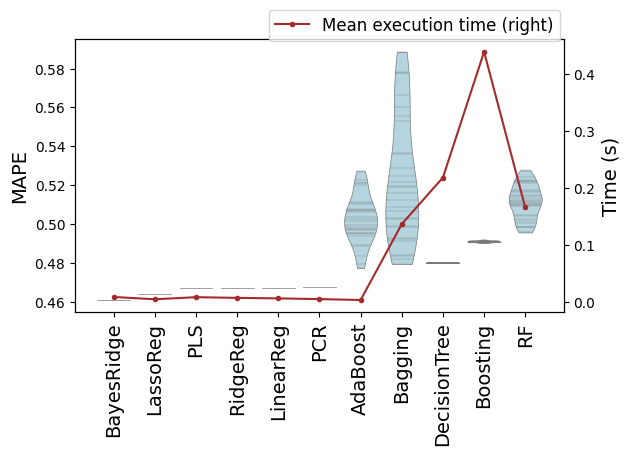

In [203]:
plt.figure()
ax = plt.gca()
sns.violinplot(x="model", y="mape", data=df_results_ed, cut=0, inner = 'stick', scale = 'width', linewidth = 0.5, color = 'lightblue')
plt.xticks(rotation = 90, fontsize = 14)
plt.ylabel('MAPE', fontsize = 14)
plt.xlabel('')

ax2 = ax.twinx()
ax2.plot(gp_results_ed.time, '.-', c = 'brown', label = 'Mean execution time (right)')
plt.ylabel('Time (s)', fontsize = 14)
plt.legend(bbox_to_anchor = (1.01, 1.14), fontsize = 12)
plt.tight_layout()
plt.show()

## Elegí BayesRidge

In [204]:
#LINK A PREDECIR
url = 'https://docs.google.com/spreadsheets/d/1reXECZNyxnuQwRrTpyXN5cbyplyCSAPZdyHdDVafMEg/gviz/tq?tqx=out:csv&tq=pred'
#LINK DE BASE
urlBase = 'https://docs.google.com/spreadsheets/d/1reXECZNyxnuQwRrTpyXN5cbyplyCSAPZdyHdDVafMEg/gviz/tq?tqx=out:csv'

response = requests.get(urlBase)

df_train = pd.read_csv(StringIO(response.text))

response_ex = requests.get(url)

df_test = pd.read_csv(StringIO(response_ex.text))
df_test = pd.read_excel("./Prueba.xlsx")

df_train['dtFecha'] = pd.to_datetime(df_train['Fecha'])
df_test['dtFecha'] = pd.to_datetime(df_test['Fecha'])
    
df_train['fecha_weekday'] = df_train['dtFecha'].dt.weekday
df_test['fecha_weekday'] = df_test['dtFecha'].dt.weekday
rolling_mean = df_train.groupby('Equipo')['Goles'].rolling(3).mean().reset_index(0, drop=True)
df_train.loc[:, 'goles_mean'] = rolling_mean

equipo_code = df_train.Equipo.astype('category').cat.codes
df_train.loc[:, 'iEquipo'] = equipo_code
oponente_code = df_train.Oponente.astype('category').cat.codes
df_train.loc[:, 'iOponente'] = oponente_code

equipo_code = df_test.Equipo.astype('category').cat.codes
df_test.loc[:, 'iEquipo'] = equipo_code
oponente_code = df_test.Oponente.astype('category').cat.codes
df_test.loc[:, 'iOponente'] = oponente_code

df_train = df_train.dropna()
df_test = df_test.dropna()
y_train = df_train['goles_mean']
x_train = df_train[['fecha_weekday', 'iEquipo', 'iOponente']]
x_test = df_test[['fecha_weekday', 'iEquipo', 'iOponente']]

model = BayesianRidge()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
df_test['Goles'] = y_pred
df_test['Goles'] = round(df_test['Goles'], 0).astype(int)
df_test = df_test.drop(columns=['dtFecha', 'fecha_weekday', 'iEquipo', 'iOponente'])
df_test

,Torneo,Jornadas,Fecha,Estadio,Árbitro,Equipo,Oponente,Goles
0,Apertura 2020,Jornada 1,2020-07-24,Victoria,Eduardo Galvan,Necaxa,Tigres U.A.N.L.,1
1,Apertura 2020,Jornada 1,2020-07-24,Victoria,Eduardo Galvan,Tigres U.A.N.L.,Necaxa,1
2,Apertura 2020,Jornada 1,2020-07-25,Akron,Jorge Rojas,Guadalajara,León,1
